In [1]:
! pip install sudachipy
! pip install sudachidict_core

In [2]:
import re
import math
import resource
import numpy as np
from urllib import request 
from pathlib import Path


import MeCab
import neologdn
import gensim
from gensim import corpora
from gensim.corpora import Dictionary


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.linear_model import LogisticRegression

In [3]:
from sudachipy import tokenizer
from sudachipy import dictionary

tokenizer_obj = dictionary.Dictionary().create()

## check sudachi

In [4]:
mode = tokenizer.Tokenizer.SplitMode.A
[(m.surface(), m.part_of_speech()) for m in tokenizer_obj.tokenize("国家公務員", mode)]

[('国家', ['名詞', '普通名詞', '一般', '*', '*', '*']),
 ('公務', ['名詞', '普通名詞', '一般', '*', '*', '*']),
 ('員', ['接尾辞', '名詞的', '一般', '*', '*', '*'])]

In [5]:
mode = tokenizer.Tokenizer.SplitMode.C
[m.part_of_speech() for m in tokenizer_obj.tokenize("国家公務員", mode)]

[['名詞', '普通名詞', '一般', '*', '*', '*']]

In [6]:
tokenizer_obj.tokenize("SUMMER", mode)[0].normalized_form()

'サマー'

## get stopword

In [7]:
sw_filename = "stopwords.txt"
if not Path(sw_filename).exists():
    res = request.urlopen("http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt").read().decode("utf-8")
    with open(sw_filename, "w") as f:
        f.write(res)
else:
    with open(sw_filename) as f:
        res = f.read()
stopwords = [line.strip() for line in res.split("\n")]
print(len(stopwords))
print(stopwords[:3])

331
['あそこ', 'あたり', 'あちら']


## create tokenizer

In [8]:
class SudachiTokenizer():
    def __init__(self, mode="C", stopwords=None, include_pos=None):
        
        if mode not in ["A", "B", "C"]:
            raise Exception("invalid mode. 'A' ,'B' or 'C'")
        self.mode = getattr(tokenizer.Tokenizer.SplitMode, mode)
        print(self.mode )
        
        if stopwords is None:
            self.stopwords = []
        else:
            self.stopwords = stopwords
        if include_pos is None:
            self.include_pos = ["名詞", "動詞", "形容詞"]
        else:
            self.include_pos = include_pos
    
    def parser(self, text):
        return tokenizer_obj.tokenize(text, self.mode)
    
    
    def tokenize(self, text, pos=False):
        res = []
        for m in self.parser(text):
            p = m.part_of_speech()
            base = m.normalized_form() #.dictionary_form()
            #print(base, ": ", p)
            if p[0] in self.include_pos and base not in self.stopwords and p[1] != "数詞":
                if pos:
                    res.append((base, p[0]))
                else:
                    res.append(base)
        return res

In [9]:
class MeCabTokenizer:
    def __init__(self, dic_dir=None, stopwords=None, include_pos=None):
        tagger_cmd = "-Ochasen"
        if dic_dir:
            tagger_cmd += " -d {}".format(dic_dir)
        mecab = MeCab.Tagger(tagger_cmd)
        self.parser = mecab.parse
        if stopwords is None:
            self.stopwords = []
        else:
            self.stopwords = stopwords
        if include_pos is None:
            self.include_pos = ["名詞", "動詞", "形容詞"]
        else:
            self.include_pos = include_pos

    def tokenize(self, text, pos=False):
        l = [line.split("\t") for line in self.parser(text).split("\n")]
        res = []
        for w in l:
            if len(w) >=4: # check nomal words (e.g. not EOS)
                p = w[3]
                group_pos = p.split("-")[0]
                base = w[2]
                if group_pos in self.include_pos and base not in self.stopwords and "数" not in p:
                    if pos:
                        res.append((base, p))
                    else:
                        res.append(base)
        return res

In [10]:
include_pos = ["名詞", "動詞", "形容詞"]

In [11]:
mecab_tokenizer = MeCabTokenizer(dic_dir="/usr/local/lib/mecab/dic/mecab-ipadic-neologd", stopwords=stopwords, include_pos=include_pos)
sudachi_tokenizer = SudachiTokenizer(mode="A", stopwords=stopwords, include_pos=include_pos+["形状詞"])

SplitMode.A


In [12]:
text = "上記のコードは命令的で冗長です。算出プロパティを利用したバージョンと比較してみましょう"

In [13]:
words = mecab_tokenizer.tokenize(text, pos=True)

In [14]:
words

[('コード', '名詞-一般'),
 ('命令', '名詞-サ変接続'),
 ('冗長', '名詞-形容動詞語幹'),
 ('算出', '名詞-サ変接続'),
 ('プロパティ', '名詞-固有名詞-一般'),
 ('利用', '名詞-サ変接続'),
 ('する', '動詞-自立'),
 ('バージョン', '名詞-一般'),
 ('比較', '名詞-サ変接続'),
 ('する', '動詞-自立'),
 ('みる', '動詞-非自立')]

In [15]:
kaomoji_reg = r'[\[|\(][^あ-ん\u30A1-\u30F4\u2E80-\u2FDF\u3005-\u3007\u3400-\u4DBF\u4E00-\u9FFF\uF900-\uFAFF\U00020000-\U0002EBEF]+?[\]|\)]'
m = re.compile(kaomoji_reg)
def normalize(text):
    text = str(text)
    text = text.replace("\n", " ")
    text = re.sub(r"http(s)?:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*", "　", text)
    text = re.sub(r"\S*@\S*\s?" ,"　", text)
    text = text.lower()
    text = re.sub(kaomoji_reg, " ", text)
    text = re.sub(r'\d+', '', text)
    text = neologdn.normalize(text)
    return text

In [16]:
mecab_tokenizer.tokenize(normalize(text), pos=False)

['コード', '命令', '冗長', '算出', 'プロパティ', '利用', 'する', 'バージョン', '比較', 'する', 'みる']

In [17]:
sudachi_tokenizer.tokenize(normalize(text), pos=False)

['コード', '命令', '冗長', '算出', 'プロパティー', '利用', '為る', 'バージョン', '比較', '為る', '見る']

In [18]:
mecab_tokenizer.tokenize("冗長", pos=True)

[('冗長', '名詞-一般')]

In [19]:
sudachi_tokenizer.tokenize("冗長", pos=True)

[('冗長', '形状詞')]

## prepare dataset

livedoor ニュースコーパス  
https://www.rondhuit.com/download.html#ldcc

In [20]:
dataset_dir = Path("/Users/tdual/Downloads/text")
dirs = [i for i in dataset_dir.iterdir() if i.is_dir()]
dirs

[PosixPath('/Users/tdual/Downloads/text/movie-enter'),
 PosixPath('/Users/tdual/Downloads/text/it-life-hack'),
 PosixPath('/Users/tdual/Downloads/text/kaden-channel'),
 PosixPath('/Users/tdual/Downloads/text/topic-news'),
 PosixPath('/Users/tdual/Downloads/text/livedoor-homme'),
 PosixPath('/Users/tdual/Downloads/text/peachy'),
 PosixPath('/Users/tdual/Downloads/text/sports-watch'),
 PosixPath('/Users/tdual/Downloads/text/dokujo-tsushin'),
 PosixPath('/Users/tdual/Downloads/text/smax')]

In [21]:
## Too many open files対策
resource.setrlimit(resource.RLIMIT_NOFILE, (8192, 9223372036854775807))

In [22]:
X_text = []
y = []
mapping_dict = {}
for d in dirs:
    label = d.name
    index = len(mapping_dict)
    mapping_dict[index] = label
    for path in d.iterdir():
        text = open(path)
        X_text.append(text.read())
        y.append(index)

In [23]:
len(X_text), len(y)

(7376, 7376)

In [24]:
X_text[0]

'http://news.livedoor.com/article/detail/5978741/\n2011-10-30T10:15:00+0900\n【DVDエンター！】誘拐犯に育てられた女が目にした真実は、孤独か幸福か\n\u30002005年11月から翌2006年7月まで読売新聞にて連載された、直木賞作家・角田光代による初の長編サスペンス『八日目の蝉』。2010年に檀れいと北乃きいの出演によりテレビドラマ化された同作が、2011年4月に永作博美と井上真央の出演によって映画化。そして、劇場公開から半年が過ぎた10月28日、DVD＆ブルーレイとなって発売されました。\n\n八日目の蝉\n\u3000妻子ある男と愛し合い、その子を身ごもりながら、あきらめざるをえなかった女。彼女は同時に、男の妻が子供を産んだことを知る。その赤ん坊を見に行った女は、突発的にその子を連れ去り、逃避行を続けた挙句、小豆島に落ち着き、母と娘として暮らしはじめる。\n\n\n不倫相手の子供を誘拐し、4年間育てた女\n\u3000永作博美が演じる野々宮希和子は、不倫相手の子を宿しながらも、彼の「いずれ妻と別れるから、それまで待ってくれ」という常套句を信じて、中絶。後遺症により、二度と子供を産めない身体となってしまいます。その後、不倫相手から彼の妻が出産したことを知らされ、別れを決意。最後に諦めをつけるため、彼らの生後6ヶ月の赤ん坊・恵理菜の顔を見た希和子でしたが、自分に笑顔で向けた恵理菜を見て、思わず誘拐。名前を変えて恵理菜を薫と名付けると、人目を避けて各地を転々とし、二人で幸せな時間を過ごしますが、辿り着いた最後の場所・小豆島で4年の逃避行に終止符を打ちます。\n\n\n誘拐犯に育てられた女\n\u30004歳になって実の両親と再会を果たした後も、世間から言われの無い中傷を受け、本当の両親との関係を築けないまま、21歳の大学生へと成長した恵理菜。過去と向き合うことを避けてきた恵理菜でしたが、劇団ひとりが演じる不倫相手・岸田孝史の子を宿し、ずっと憎み続けてきた希和子と同じ道を歩んでいることに気付いた彼女は、小池栄子が演じるルポライター・安藤千草と共に、4年間の逃亡生活を追憶する旅に出ます。希和子との幸せだった時間に触れながら、最終地・小豆島に辿り着いた恵理菜が見た真実とは？\n\n\n八日目の

In [25]:
y[0]

0

In [26]:
mapping_dict

{0: 'movie-enter',
 1: 'it-life-hack',
 2: 'kaden-channel',
 3: 'topic-news',
 4: 'livedoor-homme',
 5: 'peachy',
 6: 'sports-watch',
 7: 'dokujo-tsushin',
 8: 'smax'}

In [27]:
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, random_state=0)

In [28]:
X_text_train[0], mapping_dict[y_train[0]]

('http://news.livedoor.com/article/detail/6561018/\n2012-05-15T17:00:00+0900\nストップ違法コピー！ BSA世界ソフトウェア違法コピー調査2011の結果発表\nビジネス ソフトウェアアライアンス（BSA）は、2011年における全世界のコンピュータ・ソフトウェアの違法コピーによる被害状況をまとめた「BSA世界ソフトウェア違法コピー調査2011」（略称：違法コピー番付）の結果を発表した。今回で9回目となる違法コピー調査だが、昨年は日本の違法コピー率は20％で2003年の調査開始以来、初めて世界1位（米国、ルクセンブルク大公国と同位）を達成した。しかし、昨年から順位を2つ下げ第3位に転落。日本国内の違法コピー率は昨年の20％から21％へ増加している。日本のPC利用者のうち違法コピーソフトを取得した利用者が39％となった。\n\n国内の違法コピーによる損害額は、昨年が約1,431億円であったが今年は約1,500億円（18.75億USドル）へと増大、世界ワーストの順位は昨年同様10位だった。今回の調査結果から、世界的な傾向を計ると先進国メインのソフトウェア成熟市場より発展途上国などのソフトウェア新興市場の違法コピー率が高いことが挙げられ、その平均値は、新興市場の違法コピー率68％対成熟市場の違法コピー率24％と大きく乖離していることが分かったという。\n\nまた世界のソフトウェア違法コピー率が平均すると42％を前後している中でその損害額は約5兆745億円（634.56億USドル）となった。その起因として、先述した新興市場における違法コピー率の増大が大きく影響していると見られる。\n\n違法コピー率が急激に上昇する理由としては、組織ぐるみの違法コピーが増えることが挙げられる。社内に複数あるPCに違法コピーが行われることでコピー率は一気に跳ね上がるからだ。こうした違法コピーがまん延するのは管理者の意識の低さにあることが多い。\n\n昨年の東日本大震災の被害やいつまでたっても抜けだせない国内景気の閉塞感によって節電、省エネ、エコ、経費削減といった言葉がもてはやされているが、ソフトウェアの違法コピーは経費削減ではなく犯罪である。ビジネスソフトの違法コピーは犯罪だということを理解し、組織内に周知徹底することでこ

In [29]:
len(X_text_train)

5532

## tokenize

In [30]:
%%time
sentences_mecab = [mecab_tokenizer.tokenize(normalize(s)) for s in X_text_train]

CPU times: user 23 s, sys: 265 ms, total: 23.3 s
Wall time: 23.4 s


In [31]:
%%time
sentences_sudachi = [sudachi_tokenizer.tokenize(normalize(s)) for s in X_text_train]

CPU times: user 6min 55s, sys: 1.86 s, total: 6min 57s
Wall time: 6min 58s


## vectorize by tf-idf 

In [32]:
dictinonary_mecab = Dictionary(sentences_mecab)
dictinonary_mecab.filter_extremes(no_below=2, no_above=0.9)
dictinonary_mecab.compactify()
corpus_mecab = [dictinonary_mecab.doc2bow(w) for w in sentences_mecab]

dictinonary_sudachi = Dictionary(sentences_sudachi)
dictinonary_sudachi.filter_extremes(no_below=2, no_above=0.9)
dictinonary_sudachi.compactify()
corpus_sudachi = [dictinonary_sudachi.doc2bow(w) for w in sentences_sudachi]

In [33]:
len(dictinonary_mecab), len(dictinonary_sudachi)

(38394, 26968)

In [34]:
class Tfidf:
    def __init__(self):
        self.corpus = None


    def create_model(self, corpus, normalize=False):
        self.corpus = corpus
        self.model = gensim.models.TfidfModel(corpus, normalize=normalize, wglobal=self.normal_idf)

    def load_model(self, file_path):
        self.model = gensim.models.TfidfModel.load(file_path)

    def normal_idf(self, docfreq, totaldocs, log_base=2.0):
        """
          this is a normal idf. gensim's idf does not have + 1.0
        """
        return math.log(1.0 * totaldocs / docfreq, log_base) + 1.0


    def get_corpus_tfidf(self, corpus=None):
        if corpus is None:
            if self.corpus and len(self.corpus) > 0:
                corpus = self.corpus
            else:
                print("self.corpus is empty")
                return []
        else:
            pass
        return list(self.model[corpus])


    def get_dense_vectors(self, corpus_tfidf, num_terms):
        dense = gensim.matutils.corpus2dense(corpus_tfidf, num_terms=num_terms).T
        return dense

    def get_csc_vectors(self, corpus_tfidf, num_terms):
        vectors = gensim.matutils.corpus2csc(corpus_tfidf, num_terms=num_terms).T
        return vectors

    

In [35]:
model_mecab = Tfidf()
model_mecab.create_model(corpus_mecab)
num_terms_m = len(dictinonary_mecab)
print("num_terms: ", num_terms_m)
vectors_mecab = model_mecab.get_csc_vectors(model_mecab.get_corpus_tfidf(corpus_mecab), num_terms_m)

num_terms:  38394


In [36]:
model_sudachi = Tfidf()
model_sudachi.create_model(corpus_sudachi)
num_terms_s = len(dictinonary_sudachi)
print("num_terms: ", num_terms_s)
vectors_sudachi = model_sudachi.get_csc_vectors(model_sudachi.get_corpus_tfidf(corpus_sudachi), num_terms_s)

num_terms:  26968


In [37]:
set(dictinonary_mecab.token2id.keys()) - set(dictinonary_sudachi.token2id.keys())

{'理不尽',
 '精神科医',
 'バックスピン',
 'サウサンプトンFC',
 'つぼ',
 'E-ROTIC',
 'はち',
 '音楽配信',
 '位置情報',
 'ぼかす',
 '戦火の馬',
 'heat',
 'ざく',
 '胸の内',
 'test',
 'ティム・ディケイ',
 '精神力',
 '性能面',
 '不自由',
 '折角',
 '品川駅港南口',
 'ゴミ捨て場',
 'ミラ・ジョヴォヴィッチ',
 '権',
 '押尾学',
 '乗り換える',
 '日系企業',
 '景品表示法',
 'internet',
 'ベビーフェイス',
 '存在感',
 '日本酒',
 'お決まり',
 'Anastacia',
 'ユースケ・サンタマリア',
 '亀田興毅',
 'そのため',
 'グレイ',
 '行動派',
 '真野恵里菜',
 'チラつく',
 '廃物',
 'エコノミークラス',
 'かたい',
 'エイトレンジャー',
 '卸',
 '澤穂希',
 '縄手',
 '求人情報',
 '三浦春馬',
 '銀河帝国',
 '老眼鏡',
 '生活習慣病',
 'たのしい',
 '洗面所',
 '電動歯ブラシ',
 '電気ケトル',
 '納まる',
 '名古屋駅',
 '販売店',
 'SoftBankスマートフォン',
 '映像信号',
 '落つ',
 'ネバネバ',
 '思い当たる',
 'いまを生きる',
 'オウム事件',
 '資産運用',
 '推す',
 'MINI-Z',
 'たす',
 'ふたり',
 '物理学者',
 'サッカー解説者',
 '深層心理',
 '奥田瑛二',
 'いい',
 'どる',
 '理系男子。',
 '販売予定',
 'まころん',
 'ジョセフ',
 '観光スポット',
 '取り付ける',
 'マイコミジャーナル',
 "G'zOne",
 '興行収入',
 'ひとつひとつ',
 '思わす',
 'キングコング',
 'スイングバランス',
 'SHO',
 '葬',
 '鈴木省吾',
 '痛いニュース',
 '国内市場',
 'ファンミーティング',
 '大切さ',
 'ハイブリッド車',
 '苦肉の策',
 '送り届ける',
 'ケーブルチャンネル',
 '同窓生',
 'そばかす',
 '宮崎

In [38]:
sentences_mecab_test = [mecab_tokenizer.tokenize(normalize(s)) for s in X_text_test]
corpus_mecab_test = [dictinonary_mecab.doc2bow(w) for w in sentences_mecab_test]
vectors_test_mecab = model_mecab.get_csc_vectors(model_mecab.get_corpus_tfidf(corpus_mecab_test), num_terms_m)

In [39]:
sentences_sudachi_test = [sudachi_tokenizer.tokenize(normalize(s)) for s in X_text_test]
corpus_sudachi_test = [dictinonary_sudachi.doc2bow(w) for w in sentences_sudachi_test]
vectors_test_sudachi = model_sudachi.get_csc_vectors(model_sudachi.get_corpus_tfidf(corpus_sudachi_test), num_terms_s)

## classify by LogisticRegression

In [40]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False):

    cm = confusion_matrix(test_y,pred_y)
    classes = class_names
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center")
    fig.tight_layout()
    return ax

In [41]:
clf_m = LogisticRegression()
clf_m.fit(vectors_mecab, y_train)

/Users/tdual/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tdual/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
class_names = clf_m.classes_

In [43]:
x_test = vectors_test_mecab

acc:  0.9436008676789588
macro recall:  0.9370478971545325
macro precision:  0.943172794512064


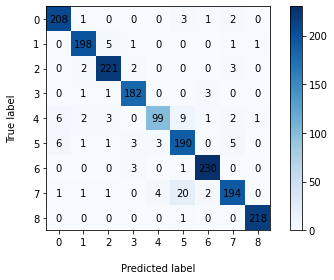

In [44]:
print("acc: ", clf_m.score(x_test, y_test))  
test_pred = clf_m.predict(x_test)
print("macro recall: ", recall_score(y_test, test_pred, average="macro"))
print("macro precision: ", precision_score(y_test, test_pred, average="macro"))
plot_confusion_matrix(y_test, test_pred, class_names,normalize=False)

In [45]:
clf_s = LogisticRegression()
clf_s.fit(vectors_sudachi, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
x_test = vectors_test_sudachi
x_test.shape

(1844, 26968)

acc:  0.9360086767895879
macro recall:  0.9279217004906994
macro precision:  0.9345703952725657


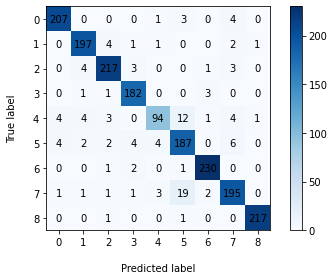

In [47]:
print("acc: ", clf_s.score(x_test, y_test))  
test_pred = clf_s.predict(x_test)
print("macro recall: ", recall_score(y_test, test_pred, average="macro"))
print("macro precision: ", precision_score(y_test, test_pred, average="macro"))
plot_confusion_matrix(y_test, test_pred, class_names, normalize=False)

In [48]:
! say Done